# Predicting Fake News - Final Report
The dataset is about fake news articles; the name of the author, the title of the article, the text of the article and whether it is fake or real is included in this dataset. It can be found on Kaggle:
https://www.kaggle.com/c/fake-news/data

### Business Problem:
A social media company has hired us to investigate fake news article and develop models that can flag articles that are fake so they can be removed from their platform and not propogate misinformation. These news articles are polarizing people on their platform and the effects are pouring over into everyday life. They want to let their users know which articles are fake by flagging them or removing them altogther. Customers are swithcing to competitor platforms where this problem has already been handled. 

### Client
Social Media Company 

### Objective
My objective is to gain insight into what features fake news articles consist of and if they can be distinguished. The ultimate goal is to create models that can accurately predict if an article is fake or not based on the text of the article. 

Overview of Analytical Pipeline
This project follows a typical data science pipeline.

1. First approach in solving the problem is obtaining the relevant data.
2. Cleaning the data is the next step. This includes checking for null values, imputing missing values and checking column names
3. Next, we explore the data to gain insights into our dataset and what it contains. This includes looking for outliers or unusual data as well as using a correlation matrix to understand the relationship between the response and predictor variables.
4. Modeling using Machine Learning gives us our predictive power on whether the news article is fake. 
5. Lastly, we interpret the results and see what can we conlcude about bank customers leaving the bank. For example, what feature variable was most indicative of customers leaving the bank?

# 1. Obtaining the Data
---

### Load libraries

In [1]:
from helper_functions import *
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import math
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


### Load and view dataset

In [2]:
df = pd.read_csv('train.csv')

In [3]:
print(df.shape)
df.head(5)

(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### Check for class imbalance

In [4]:
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

# 2. Cleaning the Data
---
The following steps were taken to clean the data: 
- Change name of the title column to article_title 
- Drop the 'id' column
- Preprocess text to make it clean. 
- Visualize null values in each column 
- Find length of text in each article and drop articles with less than 50 characters.
- Replace null values in 'author' and 'article_title' column to 'Unknown' 

In [5]:
# change title to article_title
df.rename(columns={"title": "article_title"}, inplace=True)
df.head()

,id,article_title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
# drop id column 
df.drop('id', axis=1, inplace=True)

For visual purposes, I like to move the response variable, in this case 'Exited', to the left side of the table. I find it quicker to view it this way, and also makes the dataset splitting into train/test set easier later on.

In [7]:
first_column = df['label']
df.drop('label', axis=1,inplace=True)
df.insert(0, 'label', first_column)
df.head()

,label,article_title,author,text
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,1,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,1,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,1,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [8]:
# Inspect the the data types
df.dtypes

label             int64
article_title    object
author           object
text             object
dtype: object

### Text preprocessing

In [10]:
df['text'] = preprocess(df['text'])

### Make length column containing length of text.

In [11]:
df['length'] = findlength(df, 'text')
df.head()

,label,article_title,author,text,length
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,4886
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,4143
2,1,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",7670
3,1,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,3223
4,1,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to s...,934


### Show and plot null values

author           1957
article_title     558
length              0
text                0
label               0
dtype: int64


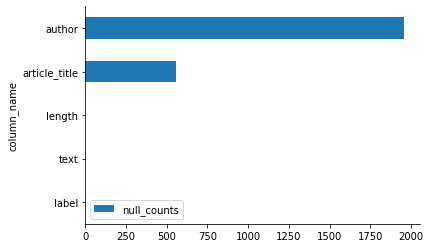

In [13]:
null_plot(df,'barh')

### Replace Null Values in 'author' and 'article_title' columns to 'Unknown'


In [14]:
values = {'author' : 'Unknown', 'article_title': 'Unknown'}
df.fillna(value=values, inplace=True)

length           0
text             0
author           0
article_title    0
label            0
dtype: int64


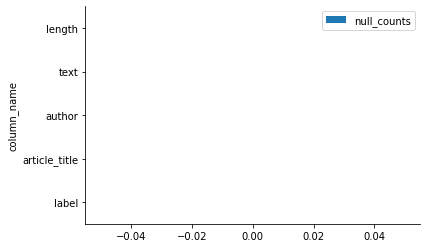

In [15]:
null_plot(df,'barh')

### Drop rows that have article length less than 50 characters


In [17]:
# Drop rows that have article length less than 50 characters
df.drop(df[df['length'] < 50].index, inplace = True) 

In [18]:
print(df.shape)
df.head(5)

(20554, 5)


,label,article_title,author,text,length
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,4886
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,4143
2,1,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",7670
3,1,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,3223
4,1,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to s...,934


# 3. Exploring the Data
---
- Add text_polarity column using TextBlob.
- Comparing distribution plots of text polarity in all, real and fake articles. 
- Draw heatmap showing correlations 
- Compare uni, bi and tri-gram word_vectors top features with and without removing stop-words in real, fake and all articles.

### Added text_polarity column. contains polarity of text on scale -1 to 1 indicating -ve to +ve.


In [19]:
df['text_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [20]:
df.head()

,label,article_title,author,text,length,text_polarity
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,4886,0.001796
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,4143,0.100880
2,1,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",7670,0.056258
3,1,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,3223,0.017497
4,1,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to s...,934,-0.012500


### Created two dataframes, one with +ve text polarity data and another with -ve text polarity data

In [21]:
neg_tp = df[df['text_polarity'] < 0]
pos_tp = df[df['text_polarity'] > 0]

### Created two dataframes, one with all fake labels data and another with real labels data


In [22]:
fake_df = df[df['label'] == 0]
real_df = df[df['label'] == 1]

# Distributions of text polarity in all articles, real articles and fake articles.

The plot below shows the distribution of text polarity across all articles seems to be evenly distributed with some articles being completely negative and completely positive.

The mean of text polarity in all articles is: 0.071
The median of text polarity in all articles is: 0.071


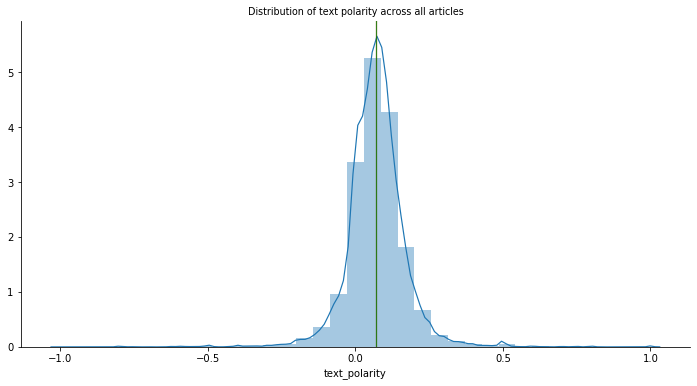

In [123]:
dist_plot(df, 'text_polarity', 'Distribution of text polarity across all articles', 'all articles')

The plow below shows the distribution of text_polarity of real text articles again seems to be evenly distributed. It also contains articles that have completely negative or positive polarity. Overall real text articles seem to have neutral polarity 


The mean of text polarity in real articles is: 0.069
The median of text polarity in real articles is: 0.065


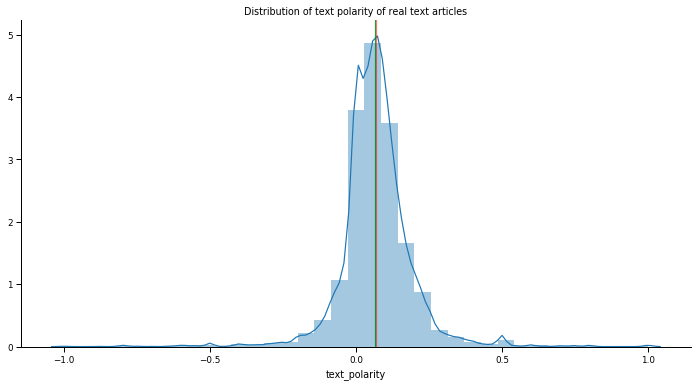

In [215]:
dist_plot(real_df, 'text_polarity', 'Distribution of text polarity of real text articles', 'real articles')

The plow below shows the distribution of text polarity of fake news articles seems to be normally distributed. An interesting thing to note is that there are no perfectly negative or positive text polarity (i.e. -1 and +1) in the
fake news articles. Overall fake text articles seem to have neutral polarity 

The mean of text polarity in fake articles is: 0.074
The median of text polarity in fake articles is: 0.075


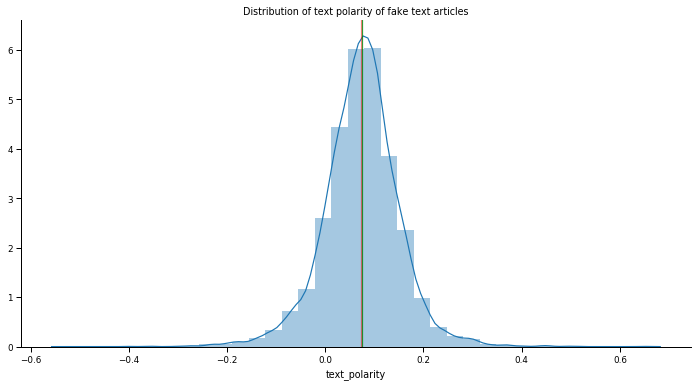

In [216]:
dist_plot(fake_df, 'text_polarity', 'Distribution of text polarity of fake text articles', 'fake articles')

## Correlation Matrix and Heatmap

To check for any correlations between the different features in the dataset, a heatmap was used. There did not seem to be any strong correlations in the dataset. The greatest correlationbvalue in the dataset was -0.12 between length and label, indicating a very weak negative correlation.

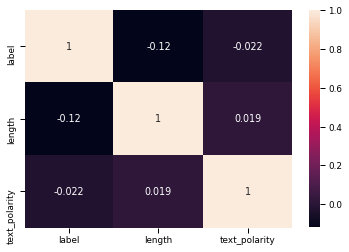

In [237]:
# Create a heatmap 
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

## Plot of top 20 unigrams, bigrams and trigrams with/without stop words removal in all, real and fake news articles


For all news articles text; without removal of stop words, the top word that occured in all articles
was **‘the’**. With the removal of stop words, the top word that occured was **‘said’**.

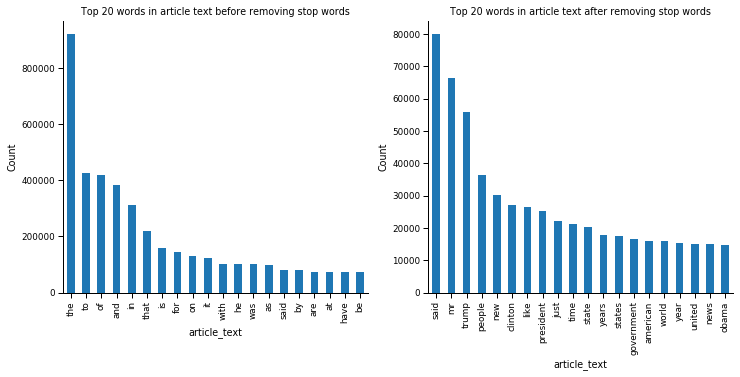

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top unigrams before removing stop words (sw)

uni_words_sw = get_top_n_words(df['text'], 20)

df1 = pd.DataFrame(uni_words_sw, columns=['article_text', 'count'])
df1.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in article text before removing stop words', ax=ax1)
ax1.set(ylabel='Count')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Top unigrams after removing stop words
uni_words_no_sw = get_top_n_words_nosw(df['text'], 20)

df2 = pd.DataFrame(uni_words_no_sw, columns=['article_text', 'count'])
ax2.set(ylabel='Count')
df2.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in article text after removing stop words', ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

For all news articles text; without removal of stop words, the top bigram that occured in all articles was **‘of the’**. With the removal of stop words, the top bigram that occured was **‘mr trump’**.

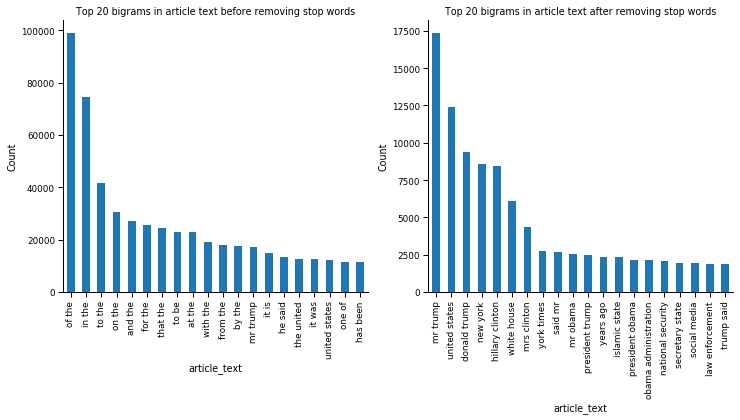

In [220]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top bigrams before removing stop words

bi_words_sw = get_top_n_bigram(df['text'], 20)

df3 = pd.DataFrame(bi_words_sw, columns=['article_text', 'count'])
df3.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top bigrams after removing stop words
bi_words_nosw = get_top_n_bigram_nosw(df['text'], 20)

df4 = pd.DataFrame(bi_words_nosw, columns=['article_text', 'count'])
df4.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

For all news articles text; without removal of stop words, the top trigram that occured in all articles was **‘the united states’**. With the removal of stop words, the top trigram that occured was **‘new york times’**.

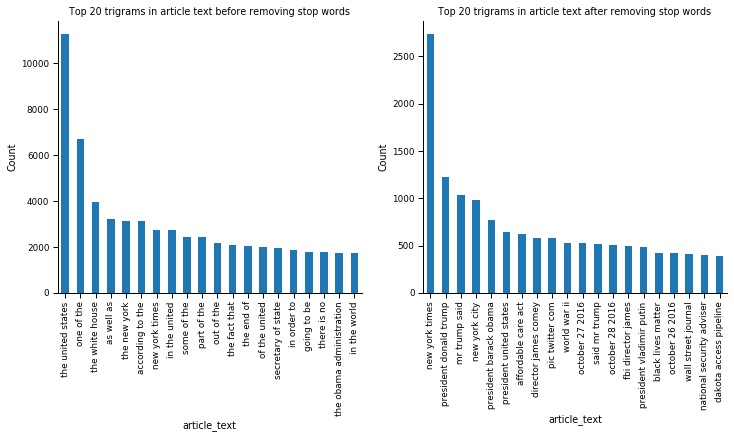

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top trigrams before removing stop words

tri_words_sw = get_top_n_trigram(df['text'], 20)

df5 = pd.DataFrame(tri_words_sw, columns=['article_text', 'count'])
df5.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top trigrams after removing stop words
tri_words_nosw = get_top_n_trigram_nosw(df['text'], 20)

df6 = pd.DataFrame(tri_words_nosw, columns=['article_text', 'count'])
df6.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

For all fake articles text; without removal of stop words, the top word that occured in
fake articles was **‘the’**. With the removal of stop words, the top trigram that occured was **‘said’**.

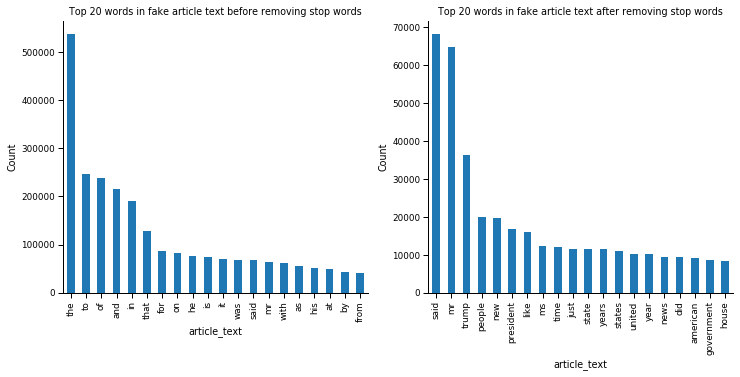

In [221]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top unigrams before removing stop words (sw) in fake articles' text 

fake_uni_words_sw = get_top_n_words(fake_df['text'], 20)

df_fake_1 = pd.DataFrame(fake_uni_words_sw, columns=['article_text', 'count'])
df_fake_1.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in fake article text before removing stop words', ax=ax1)

ax1.set(ylabel='Count')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# Top unigrams after removing stop words (sw) in fake articles' text 
fake_uni_words_no_sw = get_top_n_words_nosw(fake_df['text'], 20)

df_fake_2 = pd.DataFrame(fake_uni_words_no_sw, columns=['article_text', 'count'])
df_fake_2.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in fake article text after removing stop words', ax=ax2)
ax2.set(ylabel='Count')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

For all fake articles text; without removal of stop words, the top bigram that occured in fake articles was **‘of the’**. With the removal of stop words, the top bigram that occured was **‘mr trump’**.

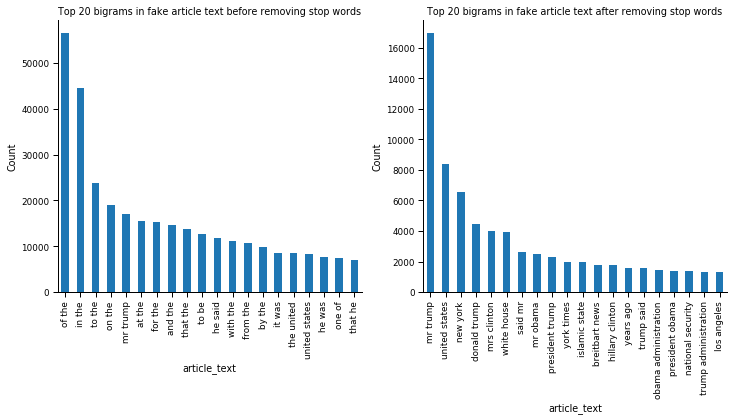

In [222]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top bigrams before removing stop words

fake_bi_words_sw = get_top_n_bigram(fake_df['text'], 20)

df_fake_3 = pd.DataFrame(fake_bi_words_sw, columns=['article_text', 'count'])
df_fake_3.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in fake article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top bigrams after removing stop words
fake_bi_words_nosw = get_top_n_bigram_nosw(fake_df['text'], 20)

df_fake_4 = pd.DataFrame(fake_bi_words_nosw, columns=['article_text', 'count'])
df_fake_4.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in fake article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

For all fake articles text; without removal of stop words, the top trigram that occured in fake articles was **‘the united states’**. With the removal of stop words, the top trigram that occured was **‘new york times’**.

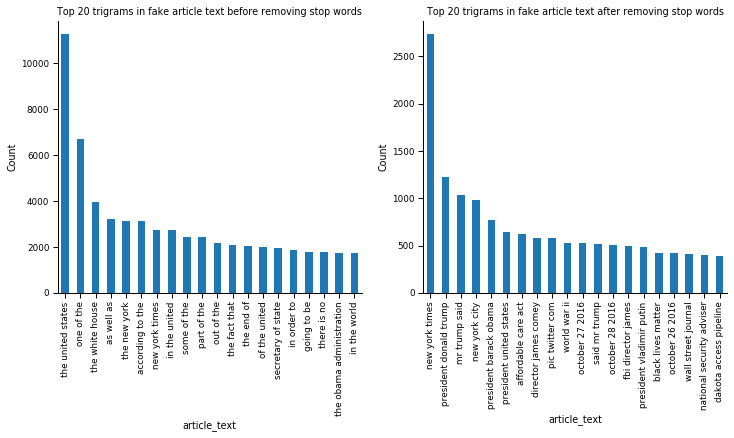

In [223]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top trigrams before removing stop words

fake_tri_words_sw = get_top_n_trigram(df['text'], 20)

df_fake_5 = pd.DataFrame(fake_tri_words_sw, columns=['article_text', 'count'])
df_fake_5.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in fake article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top trigrams after removing stop words
fake_tri_words_nosw = get_top_n_trigram_nosw(df['text'], 20)

df_fake_6 = pd.DataFrame(fake_tri_words_nosw, columns=['article_text', 'count'])
df_fake_6.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in fake article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

Finally, for all real articles text; without removal of stop words, the top word that occured in
real articles was **‘the’**. With the removal of stop words, the top word that occured was **‘trump’**.

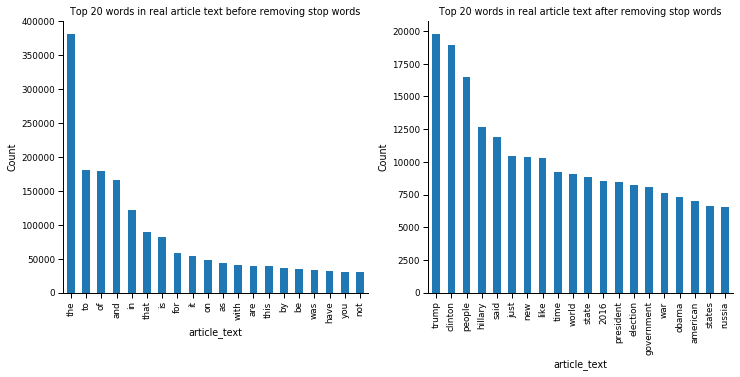

In [224]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top unigrams before removing stop words (sw) in real articles' text 

real_uni_words_sw = get_top_n_words(real_df['text'], 20)

df_real_1 = pd.DataFrame(real_uni_words_sw, columns=['article_text', 'count'])
df_real_1.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in real article text before removing stop words', ax=ax1)
ax1.set(ylabel='Count')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Top unigrams after removing stop words (sw) in real articles' text 
real_uni_words_no_sw = get_top_n_words_nosw(real_df['text'], 20)

df_real_2 = pd.DataFrame(real_uni_words_no_sw, columns=['article_text', 'count'])
df_real_2.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 words in real article text after removing stop words', ax=ax2)
ax2.set(ylabel='Count')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

Finally, for all real articles text; without removal of stop words, the top bigram that occured in real articles was **‘of the’**. With the removal of stop words, the top bigram that occured was **‘mr trump’**.

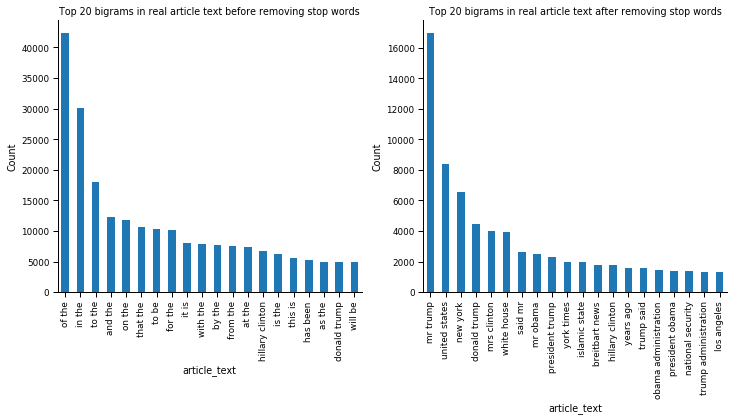

In [225]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top bigrams before removing stop words in real articles' text

real_bi_words_sw = get_top_n_bigram(real_df['text'], 20)

df_real_3 = pd.DataFrame(real_bi_words_sw, columns=['article_text', 'count'])
df_real_3.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in real article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top bigrams after removing stop words in real articles' text

real_bi_words_nosw = get_top_n_bigram_nosw(fake_df['text'], 20)

df_fake_4 = pd.DataFrame(real_bi_words_nosw, columns=['article_text', 'count'])
df_fake_4.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 bigrams in real article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

Finally, for all real articles text; without removal of stop words, the top trigram that occured in real articles was **‘the united states’**. With the removal of stop words, the top trigram that occured was **‘new york times’**.

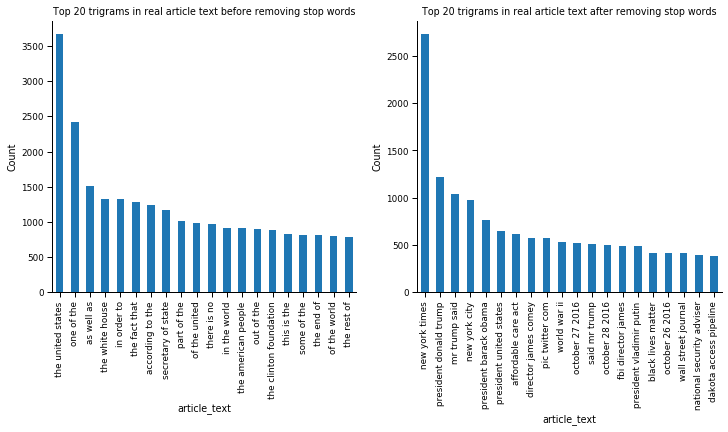

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Top trigrams before removing stop words in real articles' text

real_tri_words_sw = get_top_n_trigram(real_df['text'], 20)

df_real_5 = pd.DataFrame(real_tri_words_sw, columns=['article_text', 'count'])
df_real_5.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in real article text before removing stop words',
                                                                            ax=ax1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(ylabel= 'Count')

# Top trigrams after removing stop words in real articles' text
real_tri_words_nosw = get_top_n_trigram_nosw(df['text'], 20)

df_real_6 = pd.DataFrame(real_tri_words_nosw, columns=['article_text', 'count'])
df_real_6.groupby('article_text').sum()['count'].sort_values(ascending=False).plot(kind='bar', 
                                                                            title='Top 20 trigrams in real article text after removing stop words',
                                                                            ax=ax2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set(ylabel = 'Count')
plt.show()

# T-Test
### A t-test is a type of inferential statistic used to determine if there is a significant difference between the means of two groups, which may be related in certain features.

# One Sample T-Test

A one-sample t-test is used to test whether a population mean is significantly different from some hypothesized value. We are going to test to see whether the average text polarity of fake articles differs from the average text polarity of all articles. 

Hypothesis Testing: Is there significant difference in the means of text polarity between articles that are fake and all text articles?

**Null Hypothesis:** The null hypothesis would be there there is no difference in text polarity between articles that are fake and all text articles. 

**Alternate Hypothesis:** The alternative hypothesis would be that there is a difference in text polarity between fake articles and all articles 

In [227]:
# Look at the means of the credit score of customers who exited and all bank customers 
mean_all_articles  =   df['text_polarity'].mean()
mean_fake_articles = fake_df['text_polarity'].mean()

print('The mean text polarity of all articles is ' + str(mean_all_articles))
print('The mean text polarity of fake articles is ' + str(mean_fake_articles))

The mean text polarity of all articles is 0.07129251085549954
The mean text polarity of fake articles is 0.0735741624574898


## Conduct the T-Test

Let's conduct a t-test at 95% confidence interval and see if the null hypothesis (sample comes from the same distribution as all articles population) is correctly rejected. We can conduct a one sample t-test using the stats.ttest_1samp() function:

In [229]:
stats.ttest_1samp(a=  fake_df['text_polarity'], # Sample of text polarity ofarticles that are fake 
                  popmean = mean_all_articles) # Mean of the population

Ttest_1sampResult(statistic=3.020018793001539, pvalue=0.0025337349388929752)

The test result shows the test statistic 't' is equal to 3.0200. T is simply the calculated difference represented in units of standard error and tells us how much the sample mean deviates from the null hypothesis. We can reject the null hypothesis if the t-statistic lies outside the quantiles of the t-distribution corresponding to our confidence level and degrees of freedom. We can check the quantiles with stats.t.ppf():

T is simply the calculated difference represented in units of standard error. The greater the magnitude of T, the greater the evidence against the null hypothesis. This means there is greater evidence that there is a significant difference. The closer T is to 0, the more likely there isn't a significant difference.

In [232]:
degree_of_freedom = len(df[df['label']==1])

left_quartile = stats.t.ppf(0.025,degree_of_freedom)  # Left Quartile

right_quartile = stats.t.ppf(0.975,degree_of_freedom)  # Right Quartile

print ('The t-distribution left quartile range is: ' + str(left_quartile))
print ('The t-distribution right quartile range is: ' + str(right_quartile))

The t-distribution left quartile range is: -1.960197296450186
The t-distribution right quartile range is: 1.9601972964501855


A p-value of 0.00253 means we'd expect to see data as extreme as our sample due to chance way less than 5% of the time if the null hypothesis was true. In this case, the p-value is lower than our significance level α (equal to 1-conf.level or 0.05) so we should reject the null hypothesis. If we were to construct a 95% confidence interval for the sample it would not capture all articles text polarity mean of 0.07129251085549954:



In [235]:
sigma = fake_df['text_polarity'].std()/math.sqrt(degree_of_freedom + 1)  # Sample stdev/sample size

stats.t.interval(0.95,                        # Confidence level
                 df = degree_of_freedom,                     # Degrees of freedom
                 loc = mean_fake_articles, # Sample mean
                 scale= sigma)

(0.07207764342443139, 0.0750706814905482)

# 4. Modeling the Data
---

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between articles that are real or fake. Below is a table of the classifiers used and their respective AUC-ROC scores.

Two different methods were used to make the data ready as input each to the Multinomial NB classifier and Logistic Regression classifier. 

1. The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.
2. TF-IDF (Term Frequency – Inverse Document Frequency) are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

Benchmark Model: 
Logistic Regression was used as the benchmark model. A benchmark model is a model that is used for reference to compare how better other models are against it.

The LSTM (Long Short Term Memory) Neural Network model was created with the maximum number of words to be used to be 50,000 and the max number of words in each text to be 250. The LSTM model had a SpatialDropout1D value of 0.2, dropout value of 0.1 and recurrent dropout value of 0.1.


Classifier | AUR-ROC Score | Accuracy
---        |    ---        |   ---
Multinomial NB (Count Vectorizer) | 0.91 |0.91
Multinomial NB (TF-IDF) | 0.91 | 0.91
Logistic Regression (Count Vectorizer) | 0.95 |0.95
Logistic Regression (TF-IDF) | 0.88 | 0.88
LSTM | 0.94 | 0.94

Logistic Regression with Count Vectorizer to tokenize the data gave us the best results. It achieved an accuracy of 95% and an AUC-ROC score of 95%. Although the LSTM model achieved a higher AUC-ROC score, it would be an overkill to use it since Logistic Regression performs better in accuracy and has a great AUC-ROC score. Also, Logisitic Regression is less computationally expensive.

The worst model performance was also by Logistic Regression with TF-IDF Vectorizer achieving an accuracy and AUC-ROC score of 0.88. 

#### Model Evaluation

Apart from just using accuracy as an evaluation metric, we also use the AUC-ROC score which plots the True Positive Rate against the False Positive Rate. We should also take into consideration the False Positive and False Negative Errors to evaluate our models' performances.

False Positives (Type I Error): You predict that the article is Fake but is Real. will leave, but do not.

False Negatives (Type II Error): You predict that the article is Real but is Fake.

#### Split the data into training and test set 

In [23]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(df['text'],y, test_size=0.2, random_state=40)

#### Create count vectorizer and transform train/test data

In [24]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)


#### Create TF-IDF vectorizer and transform train/test data

In [25]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#### Create dataframes for count vectorizer and tfidf training data

In [26]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

#### Base Classifier

#### Train logistic regression with class weight balanced and C = 0.01 on CountVectorized data. 

In [345]:
log_reg_classifier(LogisticRegression, 'balanced', 0.01, count_train, y_train, count_test, y_test)



 -- Logistic Regression Model --
-- Logistic Regression Model AUC = 0.95 --
-- Logistic Regression Model with Count Vectorizer Accuracy = 0.95 --
[[1942  126]
 [  72 1971]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2068
           1       0.94      0.96      0.95      2043

    accuracy                           0.95      4111
   macro avg       0.95      0.95      0.95      4111
weighted avg       0.95      0.95      0.95      4111



#### Train logistic regression with class weight balanced and C = 0.01 on TfidfVectorized data. 

In [346]:
log_reg_classifier(LogisticRegression, 'balanced', 0.01, tfidf_train, y_train, tfidf_test, y_test)



 -- Logistic Regression Model --
-- Logistic Regression Model AUC = 0.88 --
-- Logistic Regression Model with Count Vectorizer Accuracy = 0.88 --
[[1684  384]
 [ 102 1941]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      2068
           1       0.83      0.95      0.89      2043

    accuracy                           0.88      4111
   macro avg       0.89      0.88      0.88      4111
weighted avg       0.89      0.88      0.88      4111



## Perform Hyper-Parameter Tuning

In [73]:
alphas = np.arange(0,1,0.1)

In [30]:
# -- Hyper-parameter tuning for Decision Tree Classifier -- 

classifier= MultinomialNB()
grid_param = {'alpha': alphas}
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(count_train,y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'alpha': 0.1}


In [31]:
# -- Hyper-parameter tuning for Decision Tree Classifier -- 

classifier= MultinomialNB()
grid_param = {'alpha': alphas}

gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)

gd_sr.fit(tfidf_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'alpha': 0.1}


#### Train Multinomial Naive Bayes classifier on count vectorizer data

In [351]:
mnb_classifier(MultinomialNB, 0.1, count_train, y_train, count_test, y_test)



 -- Multinomial NB Model with Count Vectorizer --


-- Multinomial NB Model with Count Vectorizer AUC = 0.91 --
-- Multinomial NB Model with Count Vectorizer Accuracy = 0.91 --


[[1991   77]
 [ 282 1761]]


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2068
           1       0.96      0.86      0.91      2043

    accuracy                           0.91      4111
   macro avg       0.92      0.91      0.91      4111
weighted avg       0.92      0.91      0.91      4111



#### Train Multinomial Naive Bayes classifier on TF-IDF vectorizer data

In [352]:
mnb_classifier(MultinomialNB, 0.1, tfidf_train, y_train, tfidf_test, y_test)



 -- Multinomial NB Model with Count Vectorizer --


-- Multinomial NB Model with Count Vectorizer AUC = 0.91 --
-- Multinomial NB Model with Count Vectorizer Accuracy = 0.91 --


[[2023   45]
 [ 306 1737]]


              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2068
           1       0.97      0.85      0.91      2043

    accuracy                           0.91      4111
   macro avg       0.92      0.91      0.91      4111
weighted avg       0.92      0.91      0.91      4111



# Create LSTM model 

Create a Long Short Term Memory Network. The maximum number of words to be used is 50,000 and the max number of words in each text is 250. The network uses a SpatialDropout1D of 0.2, a dropout rate of 0.1 and a recurrent dropout rate of 0.1. 

The EarlyStopping callback is used for validation loss. So, if for 3 consequetive tries, the validation loss does not improve by more than 0.0001, then the model will exit early. 

In [35]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [36]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 234978 unique tokens.


In [37]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (20554, 250)


In [38]:
Y = pd.get_dummies(df['label']).values

In [177]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_Train.shape,Y_Train.shape)
print(X_Test.shape,Y_Test.shape)

(16443, 250) (16443, 2)
(4111, 250) (4111, 2)


In [126]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 64

history = model.fit(X_Train, Y_Train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/momin/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14798 samples, validate on 1645 samples
Epoch 1/15
14798/14798 [==============================] - 54s 4ms/step - loss: 0.3052 - accuracy: 0.8760 - val_loss: 0.1677 - val_accuracy: 0.9380
Epoch 2/15
14798/14798 [==============================] - 55s 4ms/step - loss: 0.1228 - accuracy: 0.9570 - val_loss: 0.1980 - val_accuracy: 0.9356
Epoch 3/15
14798/14798 [==============================] - 56s 4ms/step - loss: 0.1072 - accuracy: 0.9670 - val_loss: 0.2234 - val_accuracy: 0.9252
Epoch 4/15
14798/14798 [==============================] - 57s 4ms/step - loss: 0.0395 - accuracy: 0.9878 - val_loss: 0.2194 - val_accuracy: 0.9392


In [132]:
accr = model.evaluate(X_Test,Y_Test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(accr[0],accr[1]))

4111/4111 [==============================] - 4s 925us/step
Test set
  Loss: 0.23
  Accuracy: 0.94


# Metrics

In [311]:
yhat_classes = model.predict_classes(X_Test, verbose=0)
y_temp_pred = [1 if x[1] == 1 else 0 for x in Y_Test]

In [312]:
print("-- LSTM Neural Network on Tokenized Text --")
lstm_auc_score = roc_auc_score(y_temp_pred, yhat_classes)
print("-- LSTM Neural Network on Tokenized Text AUC = %2.2f --" % lstm_auc_score)
print("-- LSTM Neural Network on Tokenized Text Accuracy = %2.2f --" % accr[1])
print("\n")
print(confusion_matrix(y_temp_pred, yhat_classes))
print("\n")
print(classification_report(y_temp_pred, yhat_classes))

-- LSTM Neural Network on Tokenized Text --
-- LSTM Neural Network on Tokenized Text AUC = 0.94 --
-- LSTM Neural Network on Tokenized Text Accuracy = 0.94 --


[[1945  113]
 [ 142 1911]]


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2058
           1       0.94      0.93      0.94      2053

    accuracy                           0.94      4111
   macro avg       0.94      0.94      0.94      4111
weighted avg       0.94      0.94      0.94      4111



# LSTM Model: Training Loss & Accuracy  vs Validation Loss & Accuracy 
----

The graph below shows model train vs validation loss. It can be seen that after 2.0 epochs, the test loss begins to flatten and train loss continues to decrease. This is an example of the model slightly overfitting in the training data as the training loss decreases but validation loss does not improve. 

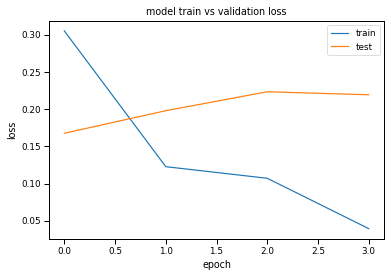

In [128]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show();

The graph below shows model train vs validation accuracy. It can be seen that after 2.0 epochs, the test loss begins to increase and train loss continues to decrease. This is an example of the model overfitting! 

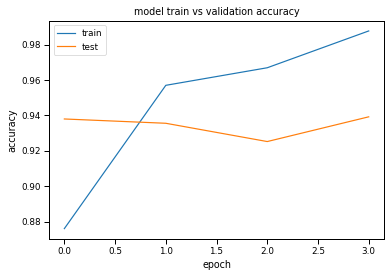

In [133]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show();

#### Create ROC Curve for LSTM mode, Logistic Regression,  Multinomial NB with Count Vectorizer and TF-IDF preprocessing steps

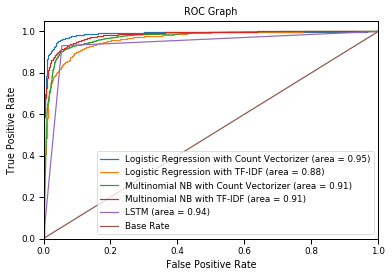

In [307]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, nb_classifier.predict_proba(count_test)[:,1])
tdidf_fpr, tdidf_tpr, tdidf_thresholds = roc_curve(y_test, nb_tfidf_classifier.predict_proba(tfidf_test)[:,1])
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, log_reg.predict_proba(count_test)[:,1])
fpr_lr_tfidf, tpr_lr_tfidf, thresholds_lr_tfidf = roc_curve(y_test, log_reg_tfidf.predict_proba(tfidf_test)[:,1])

plt.figure()

# Plot Logistic Regression ROC with Count Vectorizer 
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression with Count Vectorizer (area = %0.2f)' % log_reg_auc_score)
# Plot Logistic Regression ROC with TFIDF

plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, label='Logistic Regression with TF-IDF (area = %0.2f)' % log_reg_tfidf_auc_score)

# Plot Multinomial NB with count vectorizer 
plt.plot(fpr, tpr, label='Multinomial NB with Count Vectorizer (area = %0.2f)' % mnb_cv_auc_score)

# Plot Multinomial NB with TF-IDF
plt.plot(tdidf_fpr, tdidf_tpr, label='Multinomial NB with TF-IDF (area = %0.2f)' % mnb_tfidf_auc_score)

# Plot LSTM 
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_temp_pred, yhat_classes)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.2f})'.format(auc_keras))

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="best")
plt.show()

# 5. Interpreting the Data
---

# Summary

To recap what we have ascertained so far about bank customers from the data:

The distribution of text polarity of all articles (both fake and real) seemed evenly distributed while some articles were completely negative and completely positive in their polarity. Similarly for real articles, the text polarity appeared evenly distributed and contained articles with completely negative or positive polarity. For fake articles, the distribution of text polarity also appeared to be normally distributed. However, an interesting thing to note is there are no articles that have perfectly negative or positive text polarity (i.e. -1 and +1).

A heatmap was used to check for any correlations between the different features in the dataset. There did not seem to be any strong correlations in the dataset. The greatest correlation value in the dataset was -0.12 between length and label, indicating a very weak negative correlation.

In all news articles, without removal of stop words, the top word that occured was ‘the’. With the removal of stop words, the top word that occured was ‘said’. Similarly, without removal of stop words, the top bigram that occured was ‘of the’. With removal of stop words, the top bigram that occured was ‘mr trump’. Lastly, in all news articles, without removal of stop words the top trigram that occured was ‘the united states’. With the removal of stop words, the top trigram that occured was ‘new york times’. 

In all fake articles, without removal of stop words, the top word that occured was ‘the’. With the removal of stop words, the top word that occured was ‘said’. Similarly, without removal of stop words, the top bigram that occured was ‘of the’. With removal of stop words, the top bigram that occured was ‘mr trump’. Lastly, in all news articles, without removal of stop words the top trigram that occured was ‘the united states’. With the removal of stop words, the top trigram that occured was ‘new york times’. 

In all real articles, without removal of stop words, the top word that occured was ‘the’. With the removal of stop words, the top word that occured was ‘trump’. Similarly, without removal of stop words, the top bigram that occured was ‘of the’. With removal of stop words, the top bigram that occured was ‘mr trump’. Lastly, in all news articles, without removal of stop words the top trigram that occured was ‘the united states’. With the removal of stop words, the top trigram that occured was ‘new york times’.  


# Potential Solutions 
----

Now that we have built our classifier and also trained a deep LSTM network, both of which can be improved over time as we get more data and tweak our model settings, we can incorporate this model into the social media website. This can be done on the backend, where the model can be deployed to run against news stories that people share on the platform and flag the content as 'fake' or 'potential unverified news'. We can also discuss with the data engineering team what the best way to incorporate the model into the site would be and to make it easy, we can use kubernetes to productionize the model so newer versions of the model can replace the older version and there is no downtime or disruption of service from the users standpoint.


It is important that rather than just predicting if the news article is fake or real, we also have an estimate of the probability that the news article is fake or real. We could flag the users that share fake articles consistently, and shut down these accounts in hopes of retaining the loyal user base of the social media platform.

We can run into two sorts of problems with this approach. Firstly, consider that the news article is flagged as fake by the model, but in reality the news article is real. This is called a false positive and this mistake could be expensive, as it could lead to embarassment for the social media company and also potential loss of users. Though, this could be rectified quickly by building a mechanism to report articles that have been falsely flagged as fake. This could be one of the many directions the evolution of this project can head in. 

On the contrary, consider that the news article is flagged as real but in reality is actually fake, and continues to get shared unchecked with more and more people being exposed to the fake news while thinking it is real. This is called a false negative and it has the ability to seed distrust and polarize online users on sensitive issues using racist and hyper-nationalistic rhetoric. This is more harmful to the validity of our model as well as the reputation of the social media company, as it leads to people distrusting the platform and its ability to separate truth from lies. To mitigate this issue, a mechanism should be built that allows people to report if the article is fake and then a team assigned to fact checking the article make the ultimate decision based on their analysis. These are just some solutions that can be implemented, neither are they meant to be perfect nor do they claim to be. 

Since, this is a relatively new area and we will learn more about how to counter the different tactics employed by individuals and states to spread disinformation on social media platforms. 

To summarize all of the above mentioned points: 

Solution 1:

We can rank the articles with a probability estimate of it being real or fake, indicating how confident we think a particular article is real or fake. This will provide the readers some context and enough to decide for themselves to be skeptical of the news or not. The social media platform isn't making the decision for their users but giving them the information to decide for themselves so it does not feel like the user is being coerced into believing something or not. 
    

Solution 2: 

Provide free training to the users of the social media platform to identify fake news. For example, tips and resources can be shared that discuss common ways one can fact check a news article. It can be as simple as copy pasting information from the article into google, and seeing if the information adds up.

# Where do we go from here? 
----

This problem is about equipping the social media company with actionable knowledge regarding their ability to identify fake news on their platform and countering it. When modeling the data, we should not use the predictive metric as our final solution. Instead, we should use the information we get from modeling and arm the social media platform users so they can carry out informed decision making. 

Once the model is deployed, as more and more articles get shared on the platform, our dataset will grow. This will help make our model more accurate over time by allowing us to even test out different techniques or other models that may perform better or are more computationally efficient for our use case. For now, this model will do as it is better to have some knowledge about an article's validity than to be completely in the dark in this age of misinformation. 